In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import re  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from nltk.corpus import stopwords
from PIL import Image
import nltk
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
import os.path
from collections import Counter
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tania\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#Getting dataset
df = pd.read_csv('./tweets_large.csv')
df.shape

(358779, 12)

In [ ]:
#Data analysis from data visualization and analysis assignemt in mid-semester:

In [13]:
#pro and anti hashtags:

pro_words = ['GetVaccinated', 'GetTheJab', 'antivaxx', 'antivaxxers']
anti_words = ['plandemic', 'agenda21', 'scamdemic', 'IDoNotConsent']

#sorting pro and anti tweets into two dataframes:

pro_df = df[(df.hashtags.str.contains('|'.join(pro_words))) & (df.hashtags.str.contains('|'.join(anti_words)) == False)]

anti_df = df[df.hashtags.str.contains('|'.join(anti_words)) & (df.hashtags.str.contains('|'.join(pro_words)) == False)]

pro_np  = pro_df.to_numpy()
anti_np = anti_df.to_numpy()

concatenated = pd.concat([pro_df.assign(dataset='Pro'), anti_df.assign(dataset='Anti')])
concatenated["char_count"] = df['text'].str.len()
print("pro count", len(pro_df))
print("anti count", len(anti_df))

pro count 13617
anti count 4713


<AxesSubplot:xlabel='dataset', ylabel='count'>

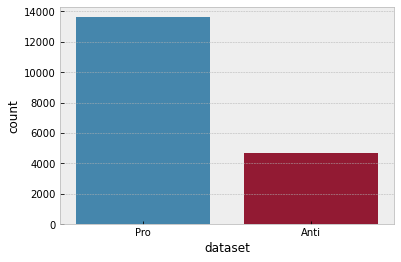

In [14]:
#Exploring difference between pro and anti count:
plt.style.use('bmh')
sns.countplot(data = concatenated, x = 'dataset')

In [ ]:
#It seems that in this dataset, there is a great number of pro-vaccination tweets and far less anti-vaccination tweets, 
#by the keywords I selected for this exploration.
#It is important to note, that the dataset consists of over 300,000 tweets, most of which were not contain the keywords
#selected here, containing keywords that can not be easily categorized as "pro" or "anti".

<AxesSubplot:xlabel='dataset', ylabel='retweetcount'>

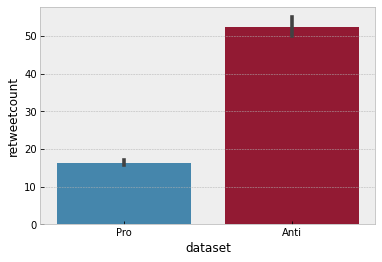

In [15]:
#Exploring difference between pro and anti in retweet count
plt.style.use('bmh')

sns.barplot(data = concatenated, x = 'dataset', y = 'retweetcount')

In [ ]:
#It looks as though "anti" tweets get far more retweets on average

In [16]:
#t test for retweets:

pro_retw = pro_df['retweetcount']
anti_retw = anti_df['retweetcount']

scipy.stats.ttest_ind(pro_retw, anti_retw)

Ttest_indResult(statistic=-39.20594776811647, pvalue=0.0)

In [ ]:
#The difference between retweet count for "pro" and "anti" tweets was statistically significant.

<AxesSubplot:xlabel='dataset', ylabel='char_count'>

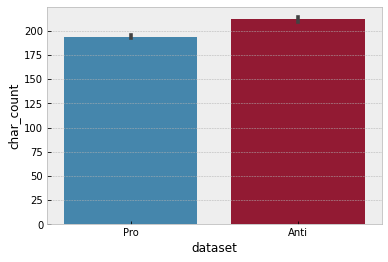

In [17]:
#Exploring difference in character count between pro and anti:
plt.style.use('bmh')
sns.barplot(data = concatenated, x = 'dataset', y = 'char_count')

In [ ]:
#There is no visible difference between "pro" and "anti" character count, but still, lets test this statistically:

In [18]:
#t test for char count:

pro_cc = pro_df['text'].str.len()
anti_cc = anti_df['text'].str.len()

scipy.stats.ttest_ind(pro_cc, anti_cc)

Ttest_indResult(statistic=-13.140637244759509, pvalue=2.89877703244393e-39)

In [19]:
print("Pro char count mean:", np.mean(pro_cc))
print("Anti char count mean:", np.mean(anti_cc))

Pro char count mean: 193.74304178600278
Anti char count mean: 211.70952684065352


In [ ]:
#The difference between "pro" and "anti" tweet character count was statistically significant, with "anti" tweets containing more
#characters on average.

<AxesSubplot:xlabel='char_count', ylabel='retweetcount'>

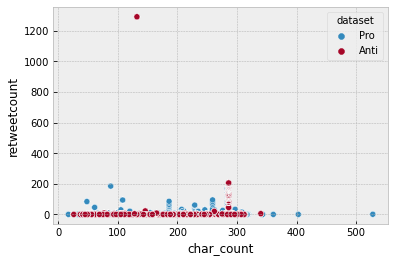

In [20]:
#Is there a relatioship between character count and retweet count per tweet?

#Visualizing relationship between retweet count and character count:
plt.style.use('bmh')
fig = plt.figure()
sns.scatterplot(data = concatenated, x = 'char_count', y = 'retweetcount', hue = 'dataset')
#sns.regplot(anti_cc, anti_retw)

In [21]:
#Exploring correlation between character count and retweet count:

np.corrcoef(pro_cc, pro_retw)

array([[1.        , 0.32717657],
       [0.32717657, 1.        ]])

In [22]:
np.corrcoef(anti_cc, anti_retw)

array([[1.        , 0.49270268],
       [0.49270268, 1.        ]])

In [23]:
scipy.stats.linregress(pro_cc, pro_retw)

LinregressResult(slope=0.1478006358000354, intercept=-12.236651947346523, rvalue=0.32717656694525427, pvalue=0.0, stderr=0.0036584758725601366, intercept_stderr=0.7684535184194398)

In [24]:
scipy.stats.linregress(anti_cc, anti_retw)

LinregressResult(slope=0.5352330465026359, intercept=-60.9294665331478, rvalue=0.49270268456708355, pvalue=8.177096060423641e-287, stderr=0.01377270921203167, intercept_stderr=3.1179824207160856)

In [ ]:
#It seems that there is some positive linear relationship between character count and retweet count for both pro and anti tweets

In [ ]:
#This is it for the earlier assignment, now starting final assignment modeling:

In [25]:
#Removing duplicate tweets
df = df.drop_duplicates(subset=['text'])

In [26]:
#Retrieving columns names
heads = list(df.columns) 
#heads are: ['username','acctdesc',  'location', 'following', 'followers', 'totaltweets', 'usercreatedts',
# 'tweetcreatedts',  'retweetcount',  'favcount',  'text',  'hashtags', 'pro_anti']
print(heads)

['username', 'acctdesc', 'location', 'following', 'followers', 'totaltweets', 'usercreatedts', 'tweetcreatedts', 'retweetcount', 'favcount', 'text', 'hashtags']


In [27]:
df.shape

(15372, 12)

In [28]:
#Getting the unequivocally categorized pro and anti tweets:
anti_words = ['plandemic', 'agenda21', 'scandemic', 'IDoNotConsent']
df['pro_anti'] = 'null'
pro_words = ['GetVaccinated', 'GetTheJab']
df.loc[(df.hashtags.str.contains('|'.join(pro_words))) & (df.hashtags.str.contains('|'.join(anti_words)) == False), 'pro_anti'] = 'pro'
df.loc[(df.hashtags.str.contains('|'.join(anti_words))) & (df.hashtags.str.contains('|'.join(pro_words)) == False), 'pro_anti'] = 'anti'
print("Anti:", df.pro_anti.value_counts()['anti'])

print("Pro:", df.pro_anti.value_counts()['pro'])

print("Not categorized:",df.pro_anti.value_counts()['null'])

Anti: 248
Pro: 597
Not categorized: 14527


In [29]:
#Taking from the dataframe categorized tweets only:

df_cat = df.loc[df.pro_anti.str.contains('pro') | df.pro_anti.str.contains('anti')]

In [30]:
#Sanity check
df_cat.shape

(845, 13)

In [31]:
#Setting X= tweet texts, y = pro/anti
X = df_cat.iloc[:,10].values
y = df_cat.iloc[:, 12]

In [32]:
#Cleaning the tweet text for tfidf
processed_tweets = []
 
for tweet in range(0, len(X)):  
    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', str(X[tweet]))
 
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
 
    # Remove single characters from the start
    processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 
 
    # Substituting multiple spaces with single space
    processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
 
    # Removing prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
 
    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()
    
    processed_tweets.append(processed_tweet)
    

In [33]:
#Setting TFIDF vectorizer
tfidfconverter = TfidfVectorizer(min_df=5, max_df=0.7, stop_words=stopwords.words('english'))  #max_features=2000, 
X = tfidfconverter.fit_transform(processed_tweets).toarray()

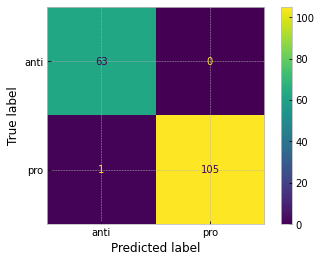

In [34]:
#Trying RandomForest classifier:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
 

rf = RandomForestClassifier(n_estimators=100, random_state=0)  
rf.fit(X_train, y_train)

plot_confusion_matrix(rf, X_test, y_test)

In [35]:
print (classification_report(y_test, (rf.predict(X_test))))

              precision    recall  f1-score   support

        anti       0.98      1.00      0.99        63
         pro       1.00      0.99      1.00       106

    accuracy                           0.99       169
   macro avg       0.99      1.00      0.99       169
weighted avg       0.99      0.99      0.99       169



In [36]:
#Training MLP classifier
mlp = MLPClassifier(hidden_layer_sizes = [100,100,100])
mlp.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=[100, 100, 100])

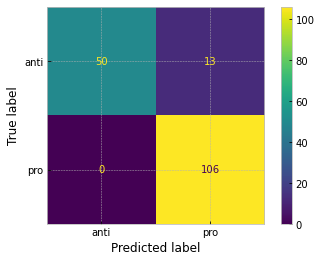

In [37]:
plot_confusion_matrix(mlp, X_test, y_test)

In [38]:
print (classification_report(y_test, (mlp.predict(X_test))))

              precision    recall  f1-score   support

        anti       1.00      0.79      0.88        63
         pro       0.89      1.00      0.94       106

    accuracy                           0.92       169
   macro avg       0.95      0.90      0.91       169
weighted avg       0.93      0.92      0.92       169



In [ ]:
#Was rather successful in test run, now lets try some more models

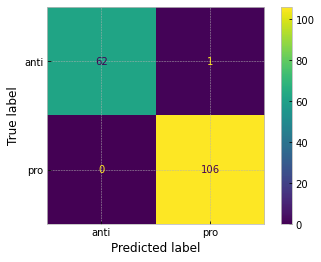

In [39]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

plot_confusion_matrix(svm, X_test, y_test)

In [40]:
print (classification_report(y_test, (svm.predict(X_test))))

              precision    recall  f1-score   support

        anti       1.00      0.98      0.99        63
         pro       0.99      1.00      1.00       106

    accuracy                           0.99       169
   macro avg       1.00      0.99      0.99       169
weighted avg       0.99      0.99      0.99       169



In [ ]:
#RandomForest and SVC did better than MLP

In [41]:
#Cevtorizing the tweets from the whole dataset:
X_full = df.iloc[:,10].values

In [ ]:
#turn into tfidf:

In [42]:
processed_tweets = []
 
for tweet in range(0, len(X_full)):  
    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', str(X_full[tweet]))
 
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
 
    # Remove single characters from the start
    processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 
 
    # Substituting multiple spaces with single space
    processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
 
    # Removing prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
 
    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()
    
    processed_tweets.append(processed_tweet)

   

In [43]:
tfidfconverter = TfidfVectorizer(max_features =459, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))  
X_full = tfidfconverter.fit_transform(processed_tweets).toarray()

In [44]:
#Predicting whole dataset with MLP
MLP_predict = mlp.predict(X_full)
df["pro_anti_MLP"] = MLP_predict

In [45]:
print("Anti:", df['pro_anti_MLP'].value_counts()['anti'])

print("Pro:", df['pro_anti_MLP'].value_counts()['pro'])

Anti: 2992
Pro: 12380


In [46]:
#Predicting whole dataset with RandomForest
RF_predict = rf.predict(X_full)

In [47]:
df["pro_anti_RF"] = RF_predict

In [48]:
print("Anti:", df['pro_anti_RF'].value_counts()['anti'])

print("Pro:", df['pro_anti_RF'].value_counts()['pro'])

Anti: 14766
Pro: 606


In [49]:
#Predicting whole dataset with SVM
SVM_predict = svm.predict(X_full)

In [50]:
df["pro_anti_SVM"] = SVM_predict

In [51]:
print("Anti:", df['pro_anti_SVM'].value_counts()['anti'])

print("Pro:", df['pro_anti_SVM'].value_counts()['pro'])

Anti: 1418
Pro: 13954


In [ ]:
#Visualizing the predictions:

<AxesSubplot:xlabel='pro_anti_MLP', ylabel='count'>

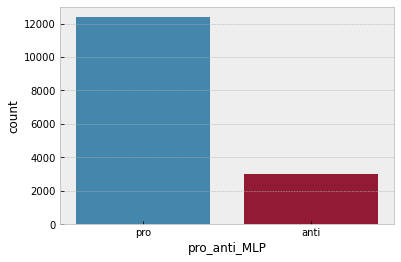

In [52]:
plt.style.use('bmh')
sns.countplot(x = 'pro_anti_MLP', data = df, order = ['pro', 'anti'])

<AxesSubplot:xlabel='pro_anti_RF', ylabel='count'>

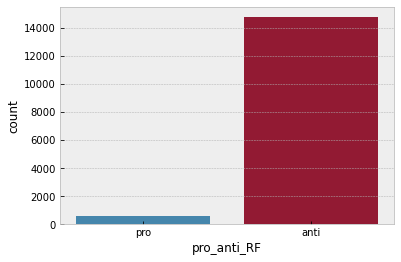

In [53]:
sns.countplot(x = 'pro_anti_RF', data = df, order = ['pro', 'anti'])

<AxesSubplot:xlabel='pro_anti_SVM', ylabel='count'>

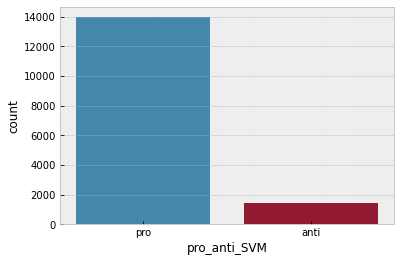

In [54]:
sns.countplot(x = 'pro_anti_SVM', data = df, order = ['pro', 'anti'])

In [ ]:
#RandomForest categorized most tweets as "anti", whereas SVM and MLP categorized most as "pro".

In [ ]:
#I will now attempt clustering into more than two categories, using K means:

In [55]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_full)
    Sum_of_squared_distances.append(km.inertia_)

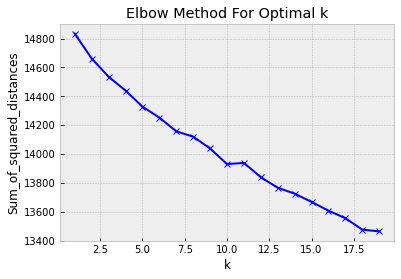

In [56]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
#Looking at the plot, chose k=10

In [57]:
true_k = 11 #loop will interate until this k-1
kmeans = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
kmeans.fit(X_full)

KMeans(max_iter=100, n_clusters=11, n_init=1)

In [58]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidfconverter.get_feature_names()

In [59]:
for i in range(true_k):
    print(i),
    for ind in order_centroids[i, :10]:
        print(terms[ind])

0
antivaxxers
covid
coronavirus
agenda21
first
us
one
great
dose
appointments
1
amp
covid19
vaccination
covid
covid19vaccine
get
health
us
dr
johnson
2
covid19
coronavirus
pandemic
lockdown
doses
new
covid
via
health
covidvaccine
3
covid19vaccine
india
covid19
first
saudi
vaccinated
dose
get
doses
still
4
people
covid19
vaccinated
uk
get
vaccination
covid19vaccine
covid
first
would
5
pfizer
biontech
covid19
dose
effective
coronavirus
pharmaceutical
covid
first
study
6
get
getvaccinated
vaccinated
covid19
covid
immunity
think
covidvaccine
wearamask
first
7
vaccines
covid19
covid
covid19vaccine
coronavirus
vaccination
covidvaccine
countries
uk
doses
8
plandemic
agenda21
remember
covid
covid19
deaths
must
make
cause
testing
9
covid
19
covid19
vaccination
covid19vaccine
coronavirus
rollout
doses
health
vaccines
10
vaccination
covid19
covid
coronavirus
health
vaccinated
via
covidvaccine
new
one


In [60]:
#Trying to predict tweets not in original dataset, as sanity check
X_test_sen = tfidfconverter.transform(["JUST IN - Chinese scientist filed a patent for a #COVID19 vaccine on behalf of the People’s Liberation Army BEFORE the virus was declared a global pandemic and later died in mysterious circumstances in 2020 (Daily Mail)"])
predicted = kmeans.predict(X_test_sen)
print(predicted)

[4]


[[ 0.4383879  -0.23345673]
 [ 0.43273523 -0.23805796]
 [ 0.4352222  -0.22996399]
 [ 0.4362219  -0.22981511]
 [ 0.43268678 -0.2296322 ]
 [ 0.43735746 -0.23657955]
 [ 0.43058655 -0.23128226]
 [ 0.43398917 -0.23836623]
 [ 0.4387519  -0.23596752]
 [ 0.43013725 -0.23631361]
 [ 0.42930883 -0.23468721]]


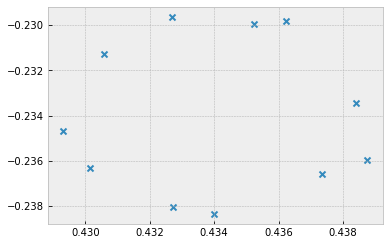

In [61]:
#Visualizing kmeans centroids
tsne_init = 'pca'  # could also be 'random'
tsne_perplexity = 20.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 10
model = TSNE(n_components=2, random_state=None, init=tsne_init,
    perplexity=tsne_perplexity,
    early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)



centroids = kmeans.cluster_centers_
transformed_centroids = model.fit_transform(centroids)
print (transformed_centroids)
plt.scatter(transformed_centroids[:, 0], transformed_centroids[:, 1], marker='x')
tf_idf_vectorizer = TfidfVectorizer(max_features =459, analyzer="word", use_idf=True, smooth_idf=True, ngram_range=(2, 3))
tf_idf_matrix = tf_idf_vectorizer.fit_transform(df.iloc[:,10].values)
plt.show()

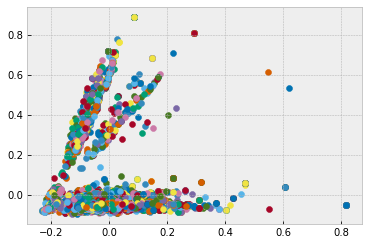

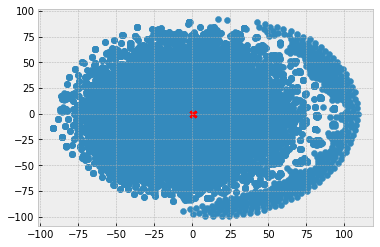

In [62]:
#Trying dimensionality reduction with tSNE and PCA
num_clusters = true_k
num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2


tf_idf_vectorizer = TfidfVectorizer(max_features =459, analyzer="word", use_idf=True, smooth_idf=True, ngram_range=(2, 3))
tf_idf_matrix = tf_idf_vectorizer.fit_transform(df.iloc[:,10].values)


labels = kmeans.fit_predict(tf_idf_matrix)
# print labels

X = tf_idf_matrix.todense()

# ----------------------------------------------------------------------------------------------------------------------

reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
# print reduced_data

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    #color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2)
plt.show()

# t-SNE plot
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X_full)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.scatter(transformed_centroids[:, 0], transformed_centroids[:, 1], marker='x', color = 'red')
plt.show()

In [ ]:
#Match original labels with kmeans labels:

In [63]:
df['K'] = pd.Series(labels, index=df.index)

In [64]:
for i in range(true_k):
    print("K = ", i, ",count = ",df.K.value_counts()[i])

K =  0 ,count =  191
K =  1 ,count =  106
K =  2 ,count =  1035
K =  3 ,count =  1042
K =  4 ,count =  498
K =  5 ,count =  204
K =  6 ,count =  10574
K =  7 ,count =  333
K =  8 ,count =  38
K =  9 ,count =  155
K =  10 ,count =  1196


<AxesSubplot:xlabel='K', ylabel='count'>

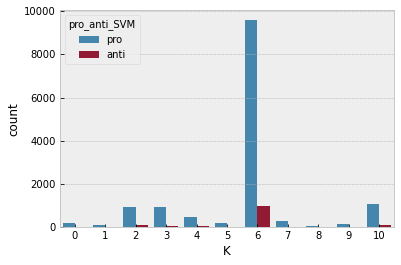

In [65]:
sns.countplot(x= df['K'], hue = df['pro_anti_SVM'])

In [ ]:
#Add label to each tweet and predict retweet count:

<AxesSubplot:xlabel='K', ylabel='retweetcount'>

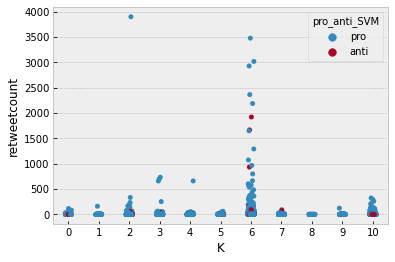

In [66]:
sns.stripplot(x= 'K', y = 'retweetcount', hue  = 'pro_anti_SVM', data = df)

In [67]:
#Due to wide distribution of retweet count, visualizing the data with log of retweet count
df['retweetcount_log'] = np.log10(df['retweetcount'].astype(np.float64)).fillna(0)

C:\Users\Tania\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [68]:
df['retweetcount_log'].replace([np.inf, -np.inf], np.nan, inplace=True)

In [69]:
df['retweetcount_log'] = df['retweetcount_log'].fillna(0)

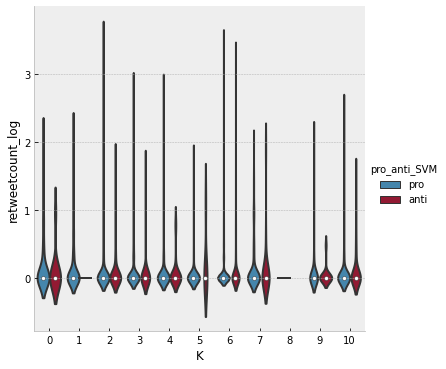

In [70]:
sns.catplot(x= 'K', y = 'retweetcount_log', hue  = 'pro_anti_SVM', kind="violin", data = df)

In [71]:
df.loc[df.retweetcount >= np.mean(df.retweetcount), 'retweet_bi'] = 1
df.loc[df.retweetcount < np.mean(df.retweetcount), 'retweet_bi'] = 0

In [ ]:
#k=0 seems to contain most tweets, both "pro" and "anti". There does not seem to be a relationship between "pro" and "anti" 
#categories and the k-means outcome

In [72]:
#Trying making retweet a binary category
X_med = df['text'].values
y_med = df['retweet_bi']

In [73]:
processed_tweets = []
 
for tweet in range(0, len(X_med)):  
    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', str(X_med[tweet]))
 
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
 
    # Remove single characters from the start
    processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 
 
    # Substituting multiple spaces with single space
    processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
 
    # Removing prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
 
    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()
    
    processed_tweets.append(processed_tweet)

   

In [74]:
tfidfconverter = TfidfVectorizer(max_features =459, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))  
X_med = tfidfconverter.fit_transform(processed_tweets).toarray()

In [75]:
X_med_train, X_med_test, y_med_train, y_med_test = train_test_split(X_med, y_med, train_size=0.8, random_state=42)

In [76]:
#Trying to predict binary retweet count using tweets
mlp_med = MLPClassifier(hidden_layer_sizes = [20,20,20,20])
mlp_med.fit(X_med_train,y_med_train)

MLPClassifier(hidden_layer_sizes=[20, 20, 20, 20])

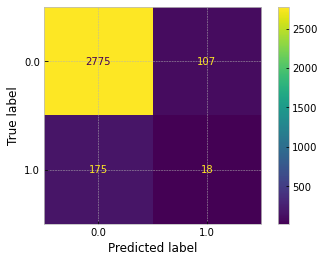

In [77]:
plot_confusion_matrix(mlp_med, X_med_test, y_med_test)

In [78]:
print (classification_report(y_med_test, (mlp_med.predict(X_med_test))))

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      2882
         1.0       0.14      0.09      0.11       193

    accuracy                           0.91      3075
   macro avg       0.54      0.53      0.53      3075
weighted avg       0.89      0.91      0.90      3075



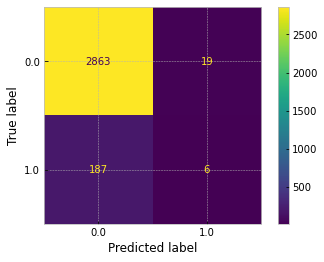

In [79]:
#Trying RandomForest classifier:

rf_med = RandomForestClassifier(n_estimators=100, random_state=0)  
rf_med.fit(X_med_train, y_med_train)
 
 
predictions_med = rf_med.predict(X_med_test)
 
plot_confusion_matrix(rf_med, X_med_test, y_med_test)

In [ ]:
print (classification_report(y_med_test, (rf_med.predict(X_med_test))))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      2882
         1.0       0.24      0.03      0.06       193

    accuracy                           0.93      3075
   macro avg       0.59      0.51      0.51      3075
weighted avg       0.89      0.93      0.91      3075



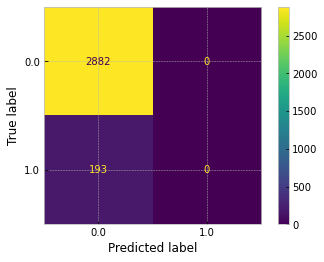

In [80]:

svm_med = SVC(kernel='linear')
svm_med.fit(X_med_train, y_med_train)

plot_confusion_matrix(svm_med, X_med_test, y_med_test)

In [ ]:
print (classification_report(y_med_test, (svm_med.predict(X_med_test))))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      2882
         1.0       0.00      0.00      0.00       193

    accuracy                           0.94      3075
   macro avg       0.47      0.50      0.48      3075
weighted avg       0.88      0.94      0.91      3075



C:\Users\Tania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Prediction did not work very well.

In [ ]:
#Adding textblob based sentiment analysis to dataset, and trying to predict "pro" and "anti" tweets using polarity and subjectivity

In [81]:
df[['polarity', 'subjectivity']] = df['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [83]:
df_cat[['polarity', 'subjectivity']] = df_cat['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [ ]:
#Exploring sentiment analysis

In [84]:
df_cat['subjectivity'].describe()

count    845.000000
mean       0.388781
std        0.294679
min        0.000000
25%        0.083333
50%        0.400000
75%        0.600000
max        1.000000
Name: subjectivity, dtype: float64

In [85]:
df['subjectivity'].describe()

count    15372.000000
mean         0.357575
std          0.292285
min          0.000000
25%          0.000000
50%          0.375000
75%          0.550000
max          1.000000
Name: subjectivity, dtype: float64

In [86]:
df_cat['polarity'].describe()

count    845.000000
mean       0.117895
std        0.279344
min       -1.000000
25%        0.000000
50%        0.033333
75%        0.250000
max        1.000000
Name: polarity, dtype: float64

In [87]:
df['polarity'].describe()

count    15372.000000
mean         0.107827
std          0.255144
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.250000
max          1.000000
Name: polarity, dtype: float64

In [88]:
X= df[['polarity', 'subjectivity']].values.reshape(-1,2)
Y =  df['retweetcount']

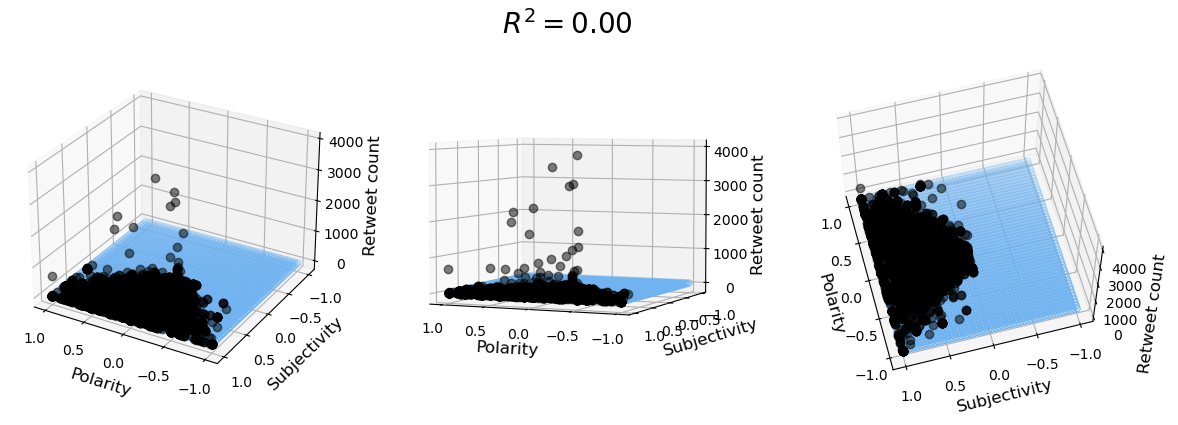

In [89]:
x = X[:, 0]
y = X[:, 1]
z = Y

x_pred = np.linspace(-1, 1)   # range of porosity values
y_pred = np.linspace(-1, 1)  # range of brittleness values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

################################################ Train #############################################

ols = linear_model.LinearRegression()
model = ols.fit(X, Y)
predicted = model.predict(model_viz)

############################################## Evaluate ############################################

r2 = model.score(X, Y)

############################################## Plot ################################################

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))


ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('Polarity', fontsize=12)
    ax.set_ylabel('Subjectivity', fontsize=12)
    ax.set_zlabel('Retweet count', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

In [90]:
ols.score(X,Y)

0.00022654113240072604

In [ ]:
#Linear regression did not work well at all.

In [92]:
#Making wordcloud for "pro" and "anti" tweets
def create_wordcloud(text):
    mask = np.array(Image.open("twitter_mask.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white", mask = mask,  max_words=3000, stopwords=stopwords, repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path="wc.png"
    display(Image.open(path))

Word Cloud Saved Successfully


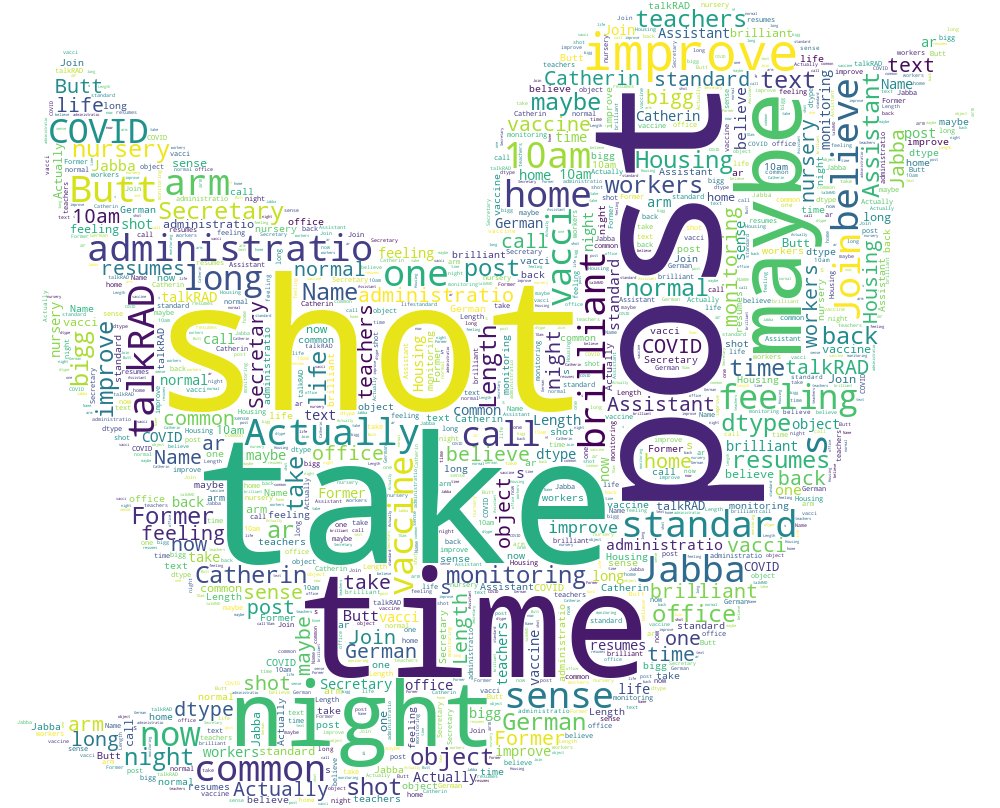

In [93]:
create_wordcloud(df.loc[df['pro_anti_SVM']=='pro', 'text'])

Word Cloud Saved Successfully


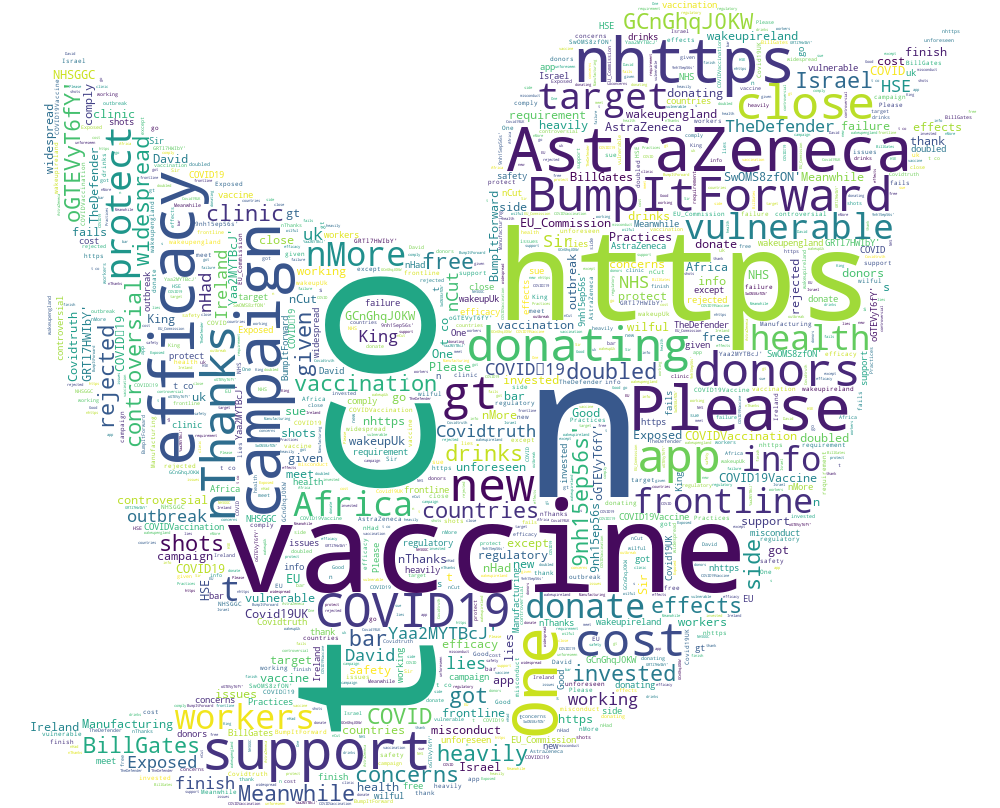

In [94]:
create_wordcloud(df.loc[df['pro_anti_SVM']=='anti', 'text'].values)

I set out to explore whether I can find a relationship between any language traits in tweets or their valence with their popularity.

In the first exercise with this data, I manually labelled the most unequivocal hashtags I used as "pro" and "anti", and used these categories to label each data point into "pro" or "anti". This left me with a subset of a little over 40,000 tweets. I then ran a series of t-tests and correlation tests to see whether I could find a difference in the popularity of tweets between the two groups. I found that retweet count did differ between the two groups (t = -40.27, p < .005). I then went on to explore whether tweet character count differed between the two groups, and it did (t = -2.08, p = .04). I also used linear regression to show the relationship between retweet count and character count, in the "pro" subset (slope=0.17, intercept=-15.75, rvalue=0.31, p < 0.005) but did not find such relationship in the the "anti" subset (p = 3.70).

Now, incorporating machine learning algorithms and a text vectorization method, I attempted to cluster the tweets again. I turned all tweet texts into vectors using TF-IDF, cleaned the tweets (i.e. removed punctuation marks, turned upper to lower case etc.) and removed duplicated. I then used a subset of tweets labelled using the most unequivocal hashtags, divided into 80% train set which I used to train three algorithms: support vector machine (SVM), RandomForest and Multilayer Perceptron (MLP). The remaining 20% of the unequivocally labelled data was used to test the algorithms and gave good scores, MLP gave a .92 accuracy score, whereas SVM and RandomForest both gave a .99 accuracy score. I then used all three algorithms to predict a "pro" or "anti" label for the entire data set. At this point, RandomForest gave an unlikely prediction, labelling most data points as "anti", hence I would not select this algorithm to work with on this data. As SVM had a higher accuracy score than MLP, I selected SVM as the best algorithm in this task.

At this point, I set out to try and cluster the data using the vectorized text and an unsupervised machine learning algorithm. Using k-means algorithm, I first iterated over various k-values and produced a sum of squared distances graph to determine the optimal k. Using the "elbow method", I selected k =  10 and trained the algorithm to cluster the tweets. Then, I wanted to examine whether any of these ten clusters corresponde with the "pro" and "anti" labels I assigned the tweets using SVM. The visualizations did not show any such connection and "pro" and "anti" labelled tweets were represented in a similar proportion in all seven clusters. 

Neither the k-means clusters nor any of the three supervised learning algorithms prediction of "pro" and "anti" labels showed a difference in representation of retweet count, meaning that the clusters did not seem to be linked to any data that could predict the tweets popularity. Results did not improve when I attempted to use retweet count as a categorical variable, recoding retweets to "0" and "1" for under and over mean retweet count. This could be due to the fact that a large proportion of tweets had null retweets. It might be valuable to try and examine this relationship in a subset of popular tweets.

I further tried to use sentiment analysis to quanitfy the level of subjectivity and polarity of tweets. I then used linear regression to predict retweet count using subectivity and polarity, but the regression model did poorly, with a score of 0.

Finally, I created two word cloud visualizations, based on word popularity, one for "pro" and one for "anti" words. Looking at the word clouds, it is apparent that there are non-word strings (URLs for example) present in the samples, which can explain some of the results. Perhaps, cleaning the data further to leave only meaningful word strings, it will be possible to arrive at more interesting results. 

To summarize, though I was not able to find the statistical relationships I set out to. I was, however, able to practice a very diverse set of modeling and visualization tools, which will undoubtedly assist me in my future research.
